## Construct PSF (fwhm, ellipticity) grids for a given RA,DEC and image_size 

### Compare PSF grids between different visits, default coadd and customized coadd.
### Compare between different bands

In [16]:
# general python packages
import numpy as np
import matplotlib.pyplot as plt  
import matplotlib.patches as patches
import itertools
%matplotlib inline

# Rubin TAP service utilities
import lsst.geom as geom
import lsst.afw.display as afwDisplay  # for image visualization
import lsst.afw.table as afwTable
from lsst.daf.butler import Butler # access to LSST data products
import lsst.daf.base as dafBase
afwDisplay.setDefaultBackend('matplotlib')

# pipeline tasks 
from lsst.pipe.tasks.calibrate import CalibrateTask
from lsst.meas.algorithms.detection import SourceDetectionTask
from lsst.meas.deblender import SourceDeblendTask
from lsst.meas.base import SingleFrameMeasurementTask
from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask, CharacterizeImageConfig
from lsst.meas.algorithms import SourceDetectionTask, SourceDetectionConfig

import warnings
from astropy.units import UnitsWarning
warnings.simplefilter("ignore", category=UnitsWarning)
warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)

In [17]:
repo = 's3://butler-us-central1-dp01'
collection = '2.2i/runs/DP0.1'
butler = Butler(repo, collections=collection)

### Select image (CUTOUT) for specific RA, DEC and filter

In [18]:
def cutout_coadd(butler, ra, dec, band='g', datasetType='deepCoadd',
                 skymap=None, cutoutSideLength=51, **kwargs):
    """
    Produce a cutout from a coadd at the given afw SpherePoint radec position.

    Adapted from DC2 tutorial notebook by Michael Wood-Vasey.

    Parameters
    ----------
    butler: lsst.daf.persistence.Butler
        Client providing access to a data repository
    ra: float
        Right ascension of the center of the cutout, degrees
    dec: float
        Declination of the center of the cutout, degrees
    filter: string
        Filter of the image to load
    datasetType: string ['deepCoadd']
        Which type of coadd to load.  Doesn't support 'calexp'
    skymap: lsst.afw.skyMap.SkyMap [optional]
        Pass in to avoid the Butler read.  Useful if you have lots of them.
    cutoutSideLength: float [optional]
        Side of the cutout region in pixels.

    Returns
    -------
    MaskedImage
    """

    radec = geom.SpherePoint(ra, dec, geom.degrees)
    cutoutSize = geom.ExtentI(cutoutSideLength, cutoutSideLength)

    if skymap is None:
        skymap = butler.get("skyMap")

    # Look up the tract, patch for the RA, Dec
    tractInfo = skymap.findTract(radec)
    patchInfo = tractInfo.findPatch(radec)
    xy = geom.PointI(tractInfo.getWcs().skyToPixel(radec))
    bbox = geom.BoxI(xy - cutoutSize//2, cutoutSize)
    patch = tractInfo.getSequentialPatchIndex(patchInfo)

    coaddId = {'tract': tractInfo.getId(), 'patch': patch, 'band': band}
    parameters = {'bbox':bbox}

    cutout_image = butler.get(datasetType, parameters=parameters, dataId=coaddId)

    return cutout_image

In [19]:
def PSF_char(ima, xp, yp):
    point = geom.Point2D(yp, xp)
    sigma = ima.getPsf().computeShape(point).getDeterminantRadius()
    pixelScale = ima.getWcs().getPixelScale().asArcseconds()
    fwhm = 2 * np.sqrt(2. * np.log(2)) * sigma * pixelScale
    return fwhm
    
def PSFgrid(ima, filt, grid_size_pix):

    xMin, yMin = ima.getBBox().getMin()
    xMax, yMax = ima.getBBox().getMax()

    x = np.arange(xMin, xMax, grid_size_pix)
    y = np.arange(yMin, yMax, grid_size_pix)
    #x_center = 0.5 * (x[:-1] + x[1:])
    #y_center = 0.5 * (y[:-1] + y[1:])
    #X, Y = np.meshgrid(x_center, y_center)
    X, Y = np.meshgrid(x,y)

    Z = []
    for iy in Y:
        for iiy in iy:
            sx = []
            for iix in X[0]:
                sx.append(PSF_char(ima, iiy, iix))
        Z.append(sx)

    Z = np.asarray(Z)
    Z = Z[:-1, :-1] 

    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    plt.sca(ax[0])  
    display1 = afwDisplay.Display(frame=fig)
    display1.scale('linear', 'zscale')
    display1.mtv(ima.image)
    display1.show_colorbar(False)
    plt.text(xMin+100,yMin+100,  filt + " band", color = 'y', fontsize=25)
    #ax[0].axis('off')

    plt.sca(ax[1])
    display2 = afwDisplay.Display(frame=fig)
    plot = plt.pcolormesh(X, Y, Z, cmap='cool', shading='flat')
    bar = plt.colorbar(plot)
    bar.set_label('FWHM [asec]')
    #ax[1].axis('off')
    plt.tight_layout()
    plt.show()

def PSFgrid_CoaddCutout(ra, dec, filt, ima_size_pix, grid_size_pix):
    ima = cutout_coadd(butler, ra, dec, band=filt, datasetType='deepCoadd', cutoutSideLength=ima_size_pix)
    PSFgrid(ima, filt, grid_size_pix)

def PSFgrid_Calexp(visit, detector, filt, ima_size_pix, grid_size_pix):
    dataId = {'visit': visit, 'detector': detector, 'band': filt}
    ima = butler.get('calexp', dataId=dataId)
    
    PSFgrid(ima, filt, grid_size_pix)
    

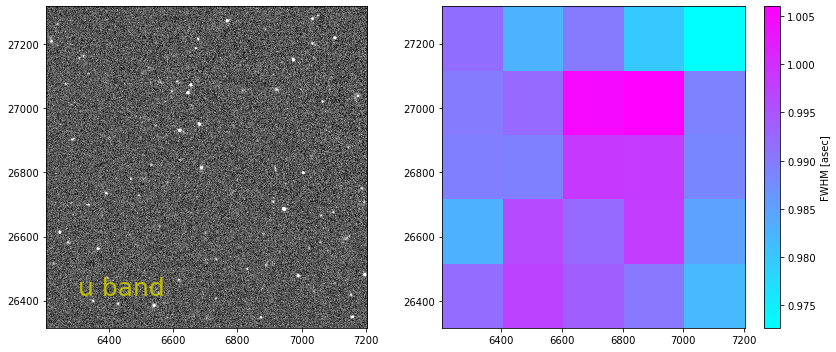

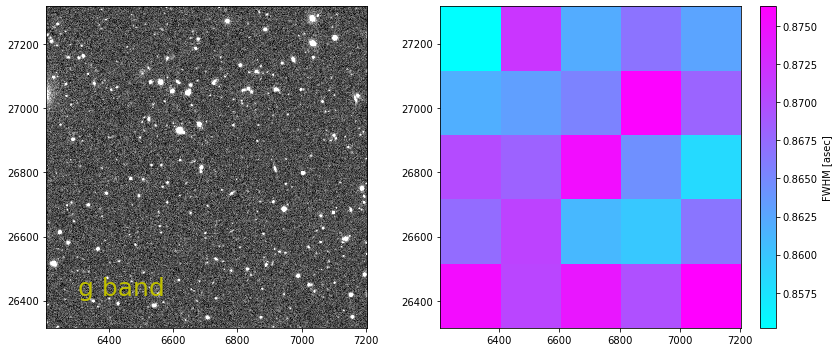

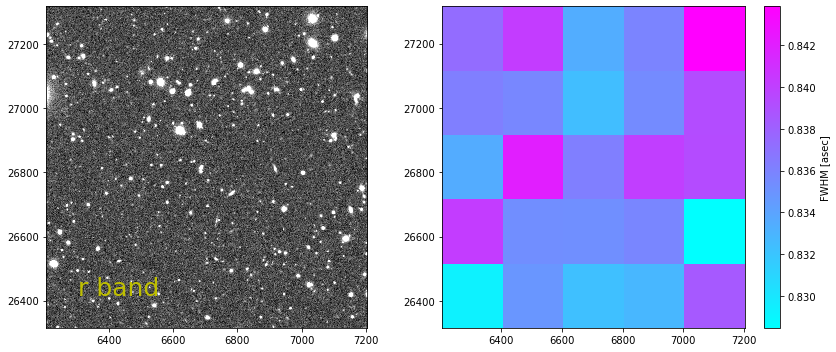

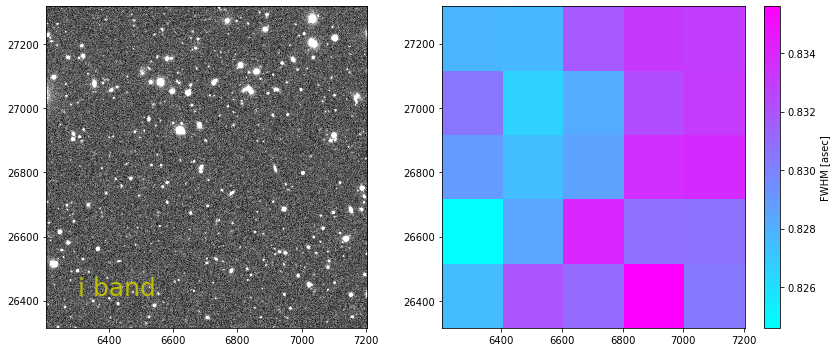

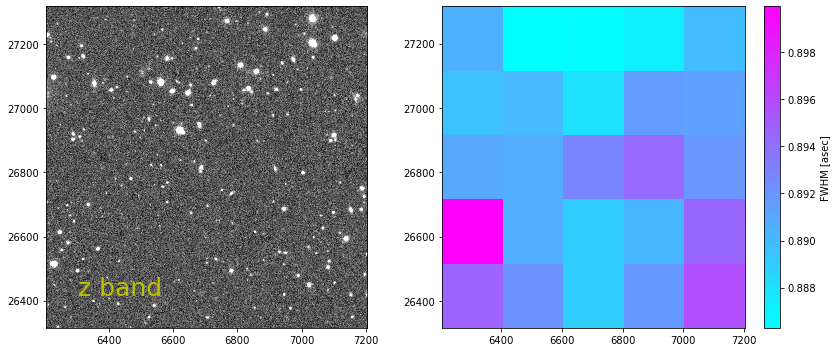

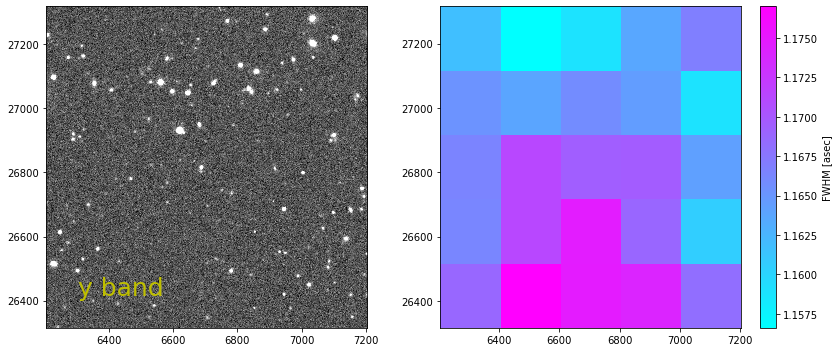

In [15]:
for f in ('u','g', 'r', 'i', 'z', 'y'):
    PSFgrid_CoaddCutout(55.064, -29.783, f, 1002, 200)
    #PSFgrid_cutout(55.064, -29.783, f, 2001, 200)

## Measure PSF in coadd

In [20]:
ra, dec = 55.064, -29.783
cutout2 = cutout_coadd(butler, ra, dec, band='g', datasetType='deepCoadd', cutoutSideLength=1000)

# Characterization, source detection and measurement
schema = afwTable.SourceTable.makeMinimalSchema()
config = CharacterizeImageTask.ConfigClass()
config.psfIterations = 1
charImageTask = CharacterizeImageTask(config=config)
config = SourceDetectionTask.ConfigClass()
config.thresholdValue = 10
config.thresholdType = "stdev"
sourceDetectionTask = SourceDetectionTask(schema=schema, config=config)
sourceDeblendTask = SourceDeblendTask(schema=schema)

algMetadata = dafBase.PropertyList()
config = SingleFrameMeasurementTask.ConfigClass()
sourceMeasurementTask = SingleFrameMeasurementTask(schema=schema, config=config, algMetadata=algMetadata)

tab = afwTable.SourceTable.make(schema)
result = sourceDetectionTask.run(tab, cutout2)
sources = result.sources

sourceDeblendTask.run(cutout2, sources)
sourceMeasurementTask.run(measCat=sources, exposure=cutout2)
sources = sources.copy(True)


## Extract the visits used to construct the coadd

In [21]:
ra, dec = 55.064, -29.783
cutout = cutout_coadd(butler, ra, dec, band='g', datasetType='deepCoadd', cutoutSideLength=1000)

v = []
for i in cutout.getInfo().getCoaddInputs().ccds:
    v.append([i['visit'], i['ccd']]) 


In [ ]:
'''
ra, dec = 55.064, -29.783
radec = geom.SpherePoint(ra, dec, geom.degrees)
for t in v[0:5]:
    dataId = {'visit': t[0], 'detector': t[1], 'band':'g'}
    calexp = butler.get('calexp',**dataId)
    calexp=calexp.getCutout(radec, size=geom.Extent2I(200, 200))
    fig = plt.figure()
    display = afwDisplay.Display(1)
    display.scale("linear", "zscale")
    display.mtv(calexp.image)
    xy = geom.PointI(calexp.getWcs().skyToPixel(radec))
    display.dot('o', xy[0],xy[1], size=20, ctype='orange')
    plt.show()
    # clean up memory
    remove_figure(fig)
'''    

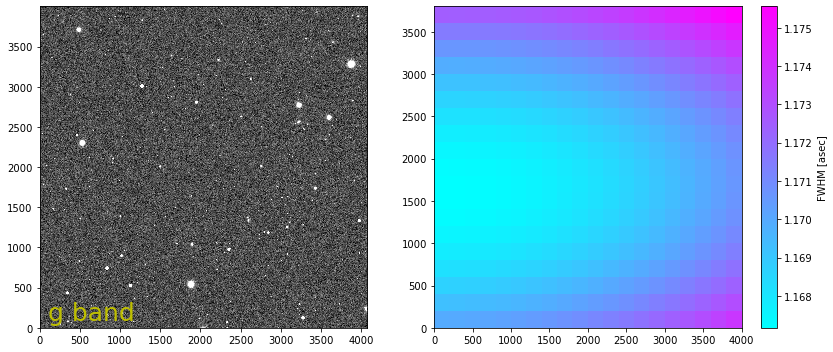

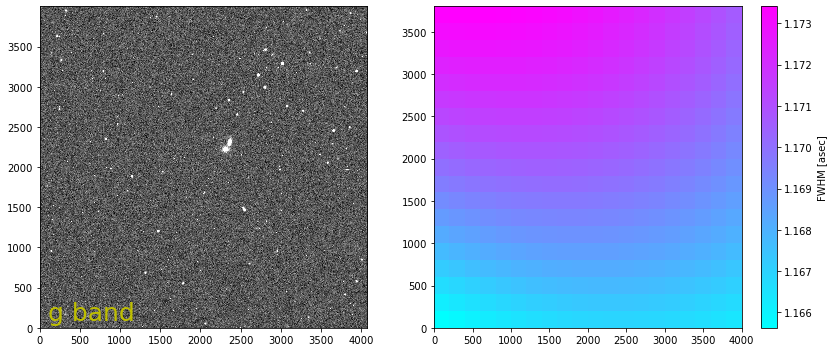

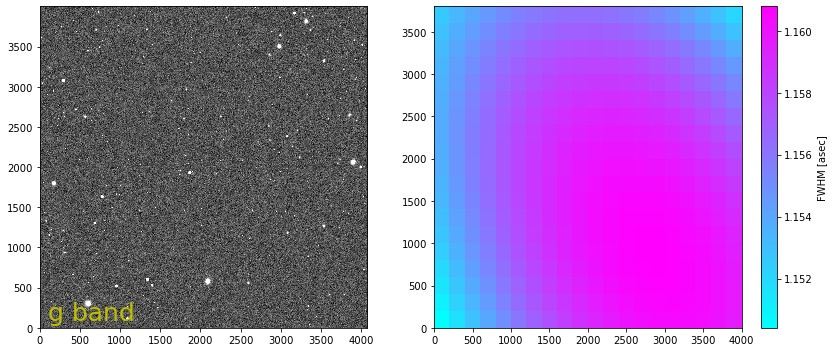

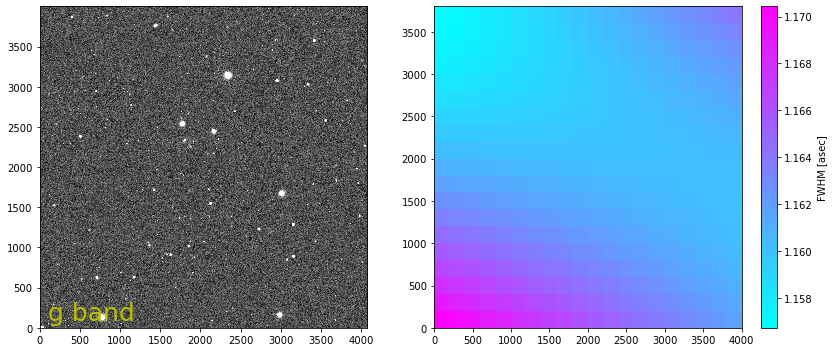

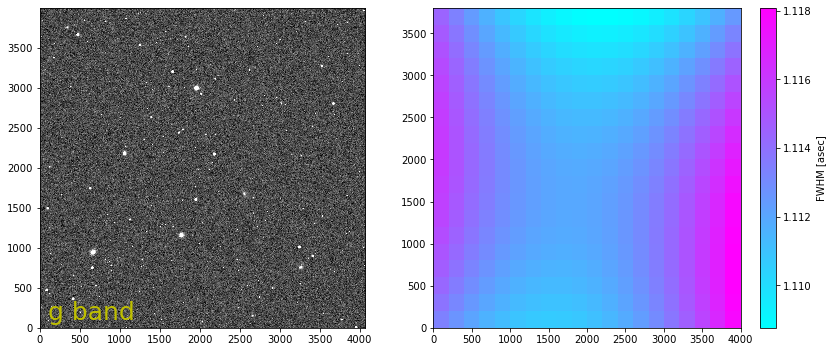

In [22]:
for t in v[0:5]:
    PSFgrid_Calexp(t[0], t[1], 'g', 1002, 200)

In [23]:
v[0:3]

[[159494, 23], [159494, 26], [183811, 3]]

In [24]:
# https://community.lsst.org/t/visualizing-source-images-in-a-coadd/441/3
def ccdVennDiagram(exp, showImage=True, legendLocation='best', vi=0):
    '''
    Create a figure with the bounding boxes for each of the images which go into a coadd,
    over-plotting the given exposure object.
    exp [in] - (Exposure) The exposure object to plot, must be the product of a coadd
    Optional:
    showImage [in] - (Bool) Plot the data in exp in addition to just it`s bounding box, default True
    LegendLocation [in] - (String) Matplotlib legend location code, can be: 'best', 'upper right',
                             'upper left', 'lower left', 'lower right', 'right', center left',
                             'center right', 'lower center', 'upper center', 'center'
    '''
    # Create the figure object
    fig = plt.figure(figsize=(8,8))
    # Use all the built in matplotib line style attributes to create a list of the possible styles
    linestyles = ['solid','dashed','dashdot','dotted']
    colors = ['b','g','r','c','m','y','k']
    # Calculate the cartisian product of the styles, and randomize the order, to help each CCD get
    # it's own color
    pcomb = np.random.permutation(list(itertools.product(colors, linestyles)))
    # Filter out a black solid box, as that will be the style of the given exp object
    pcomb = pcomb[((pcomb[:,0] == 'k') * (pcomb[:,1] == 'solid')) == False]
    # Get the image properties
    origin = geom.PointD(exp.getXY0())
    mainBox = exp.getBBox().getCorners()
    # Plot the exposure
    plt.gca().add_patch(patches.Rectangle((0,0),*list(mainBox[2]-mainBox[0]), fill=False, label="coadd ("+str(vi)+")"))
    # Grab all of the CCDs that went into creating the exposure
    ccds = exp.getInfo().getCoaddInputs().ccds
    # Loop over and plot the extents of each ccd
    
    i=0
    for ccd in cutout.getInfo().getCoaddInputs().ccds: 
        if ccd['visit'] == vi:
            #print(i,ccd)
            i = i+1
    #for i,ccd in enumerate(ccds[0:6]):
            ccdBox = geom.Box2D(ccd.getBBox())
            ccdCorners = ccdBox.getCorners()
            coaddCorners = [exp.getWcs().skyToPixel(ccd.getWcs().pixelToSky(point)) + \
                        (geom.PointD() - origin) for point in ccdCorners]


            plt.gca().add_patch(patches.Polygon(coaddCorners, fill=False, color=pcomb[i][0], ls=pcomb[i][1], label="CCD{}".format(ccd['ccd'])))
            #plt.gca().add_patch(patches.Rectangle(coaddCorners[0], *list(coaddCorners[2]-    coaddCorners[0]), fill=False, label="CCD{}".format(ccd['ccd'])))
    # If showImage is true, plot the data contained in exp as well as the boundrys
    if showImage:
        plt.imshow(exp.image.getArray(), cmap='Greys', origin='lower')
        #plt.imshow(exp.getMaskedImage().getArrays()[0], cmap='Greys', origin='lower')
        #plt.colorbar()
    # Adjust plot parameters and plot
    plt.gca().relim()
    plt.gca().autoscale_view()
    ylim = plt.gca().get_ylim()
    xlim = plt.gca().get_xlim()
    plt.gca().set_ylim(1.5*ylim[0], 1.5*ylim[1])
    plt.gca().set_xlim(1.5*xlim[0], 1.5*xlim[1])
    plt.legend(loc=legendLocation)
    fig.canvas.draw()

In [25]:
unique_visits = list(set([i['visit'] for i in cutout.getInfo().getCoaddInputs().ccds]))

In [26]:
len(unique_visits)

64

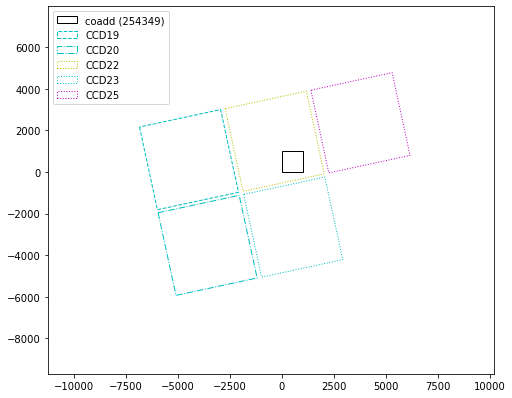

In [27]:
ccdVennDiagram(cutout, showImage=True, legendLocation='best', vi=254349)

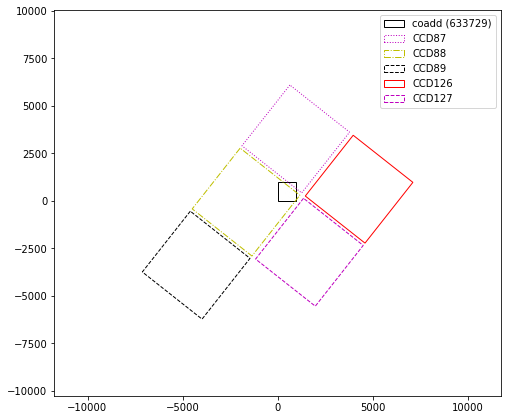

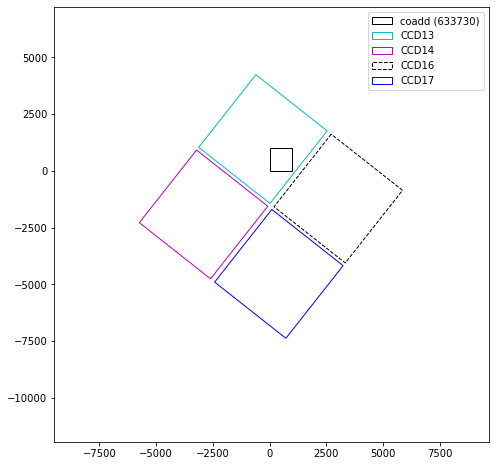

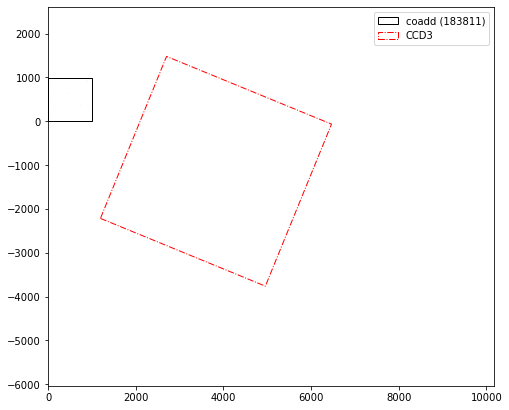

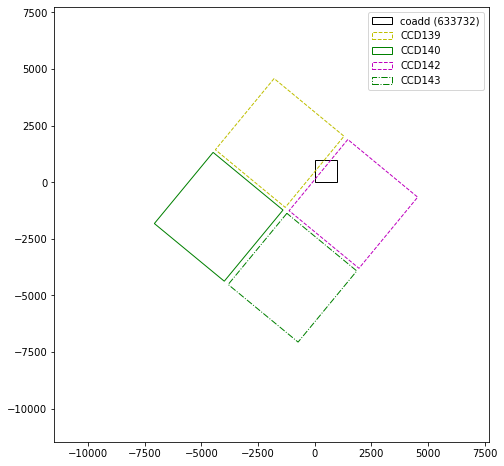

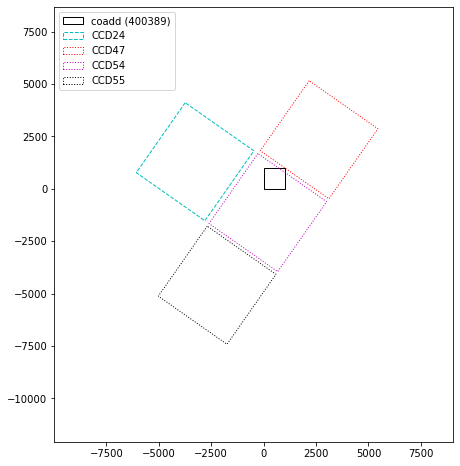

In [28]:
for uu in unique_visits[0:5]:
    ccdVennDiagram(cutout, showImage=True, legendLocation='best', vi=uu)

# COADD CALEXPS

In [29]:
# check if any of the cutout corners are within a calexp, if true, add it. 

In [30]:
unique_visits[0:5]

[633729, 633730, 183811, 633732, 400389]

In [31]:
#args = "visit = " +str(254349) + " AND detector in (19, 20, 22)"
args = "visit in (633729, 633730, 183811, 633732, 400389)"

In [32]:
'''
! butler create GEN3_run

! butler register-instrument GEN3_run/ lsst.obs.subaru.HyperSuprimeCam

! butler import GEN3_run/ ~/lsst_stack/DATA_gen3/ --export-file exports.yaml

! butler make-discrete-skymap test1/GEN3_run HSC --collections demo_collection

! pipetask run  -b GEN3_run/ --input demo_collection --input skymaps  --register-dataset-types 
    -p "${PIPE_TASKS_DIR}/pipelines/DRP.yaml"#coaddition
    --instrument lsst.obs.subaru.HyperSuprimeCam --output-run coadd -c makeWarp:doApplySkyCorr=False -c
    makeWarp:doApplyExternalSkyWcs=False -c makeWarp:doApplyExternalPhotoCalib=False 
    -c assembleCoadd:doMaskBrightObjects=False
    
LSSTCam-imSim
'''

'\n! butler create GEN3_run\n\n! butler register-instrument GEN3_run/ lsst.obs.subaru.HyperSuprimeCam\n\n! butler import GEN3_run/ ~/lsst_stack/DATA_gen3/ --export-file exports.yaml\n\n! butler make-discrete-skymap test1/GEN3_run HSC --collections demo_collection\n\n! pipetask run  -b GEN3_run/ --input demo_collection --input skymaps  --register-dataset-types \n    -p "${PIPE_TASKS_DIR}/pipelines/DRP.yaml"#coaddition\n    --instrument lsst.obs.subaru.HyperSuprimeCam --output-run coadd -c makeWarp:doApplySkyCorr=False -c\n    makeWarp:doApplyExternalSkyWcs=False -c makeWarp:doApplyExternalPhotoCalib=False \n    -c assembleCoadd:doMaskBrightObjects=False\n    \nLSSTCam-imSim\n'

In [33]:
collection_X = '2.2i/runs/DP0.1'
butler = Butler(repo, collections=collection_X)
skymap = butler.get('skyMap')

ra, dec = 55.064, -29.783
radec = geom.SpherePoint(ra, dec, geom.degrees)
tractInfo = skymap.findTract(radec)
patchInfo = tractInfo.findPatch(radec)
patch = tractInfo.getSequentialPatchIndex(patchInfo)

registry = butler.registry
for c in sorted(registry.queryCollections()):
    print(c)

2.2i/calib
2.2i/calib/PREOPS-301
2.2i/calib/PREOPS-301/unbounded
2.2i/calib/gen2
2.2i/calib/gen2/20220101T000000Z
2.2i/calib/gen2/20220806T000000Z
2.2i/defaults
2.2i/defaults/DP0
2.2i/defaults/test-med-1
2.2i/raw/DP0
2.2i/raw/all
2.2i/raw/test-med-1
2.2i/runs/DP0.1
2.2i/runs/DP0.1/calexp/v1
2.2i/runs/DP0.1/coadd/wfd/dr6/v1
2.2i/runs/DP0.1/coadd/wfd/dr6/v1/grizy
2.2i/runs/DP0.1/coadd/wfd/dr6/v1/u
refcats
refcats/PREOPS-301
skymaps
u/arunkannawadi/testRepo
u/arunkannawadi/testRepo/20210716T043324Z
u/arunkannawadi/testRepo/20210716T043512Z
u/arunkannawadi/testRepo/20210716T043805Z
u/erosas/panoptes-test4
u/erosas/panoptes-test5
u/erosas/zooniverse-test
u/erosas/zooniverse-test-2
u/erosas@lsst.org/change-this2
u/erosas@lsst.org/db-test
u/erosas@lsst.org/panoptes-test
u/erosas@lsst.org/panoptes-test2
u/erosas@lsst.org/panoptes-test3
u/erosas@lsst.org/zooniverse-test
u/jjbuchanan/remoteWriteTest
u/jjbuchanan/remoteWriteTestFullRun


In [34]:
#! butler create GEN3_run
#! butler register-instrument ./GEN3_run lsst.obs.lsst.LsstCamImSim

In [35]:
#args = "visit = " +str(254349) + " AND detector in (19, 20, 22)"

! pipetask run -b ./GEN3_run --input '2.2i/runs/DP0.1' --input skymaps --register-dataset-types\
             -d args \
             -p "${PIPE_TASKS_DIR}/pipelines/DRP.yaml" \
             --instrument lsst.obs.lsst.LsstCamImSim --output-run coadd

lsst.daf.butler.cli.utils ERROR: Caught an exception, details are in traceback:
Traceback (most recent call last):
  File "/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/ctrl_mpexec/g768b03a34c+18099b7fc4/python/lsst/ctrl/mpexec/cli/cmd/commands.py", line 126, in run
    qgraph = script.qgraph(pipelineObj=pipeline, **kwargs)
  File "/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/ctrl_mpexec/g768b03a34c+18099b7fc4/python/lsst/ctrl/mpexec/cli/script/qgraph.py", line 183, in qgraph
    qgraph = f.makeGraph(pipelineObj, args)
  File "/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/ctrl_mpexec/g768b03a34c+18099b7fc4/python/lsst/ctrl/mpexec/cmdLineFwk.py", line 561, in makeGraph
    registry, collections, run = _ButlerFactory.makeRegistryAndCollections(args)
  File "/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/ctrl_mpexec/g768b03a34c+18099b7fc4/python/lsst/ctrl/mpexec/cmdLineFwk.py", line 350, in makeRegistryAnd

In [36]:
'''
! pipetask run -b ./GEN3_run/butler.yaml \
             -d args \
             -p ${PIPE_TASKS_DIR}/pipelines/DRP.yaml#makeWarp \
             --register-dataset-types
'''

! pipetask run -b ./GEN3_run/butler.yaml \
             -d args \
             -p ${PIPE_TASKS_DIR}/pipelines/DRP.yaml#makeWarp \
             --instrument lsst.obs.lsst.LsstCamImSim  \
             -o u/$USER/warps \
             --register-dataset-types

'''
! pipetask run -b ./GEN3_run/butler.yaml \
             -d args \
             -p ${PIPE_TASKS_DIR}/pipelines/DRP.yaml#assembleCoadd \
             -i u/$USER/warps \
             -o u/$USER/coadds \
             --register-dataset-types
'''

lsst.daf.butler.cli.utils ERROR: Caught an exception, details are in traceback:
Traceback (most recent call last):
  File "/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/pipe_base/g26724298ab+308922cbb4/python/lsst/pipe/base/pipeline.py", line 874, in makeDatasetTypesSet
    registryDatasetType = registry.getDatasetType(c.name)
  File "/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/daf_butler/gbc02ca69e9+7f943868d5/python/lsst/daf/butler/registries/sql.py", line 407, in getDatasetType
    return self._managers.datasets[name].datasetType
  File "/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/daf_butler/gbc02ca69e9+7f943868d5/python/lsst/daf/butler/registry/interfaces/_datasets.py", line 520, in __getitem__
    raise KeyError(f"Dataset type with name '{name}' not found.")
KeyError: "Dataset type with name 'calexp.wcs' not found."

During handling of the above exception, another exception occurred:

Traceback (most recent call la

'\n! pipetask run -b ./GEN3_run/butler.yaml              -d args              -p ${PIPE_TASKS_DIR}/pipelines/DRP.yaml#assembleCoadd              -i u/$USER/warps              -o u/$USER/coadds              --register-dataset-types\n'

In [37]:
! pipetask run -b ./GEN3_run \
             -d args \
             -p "${PIPE_TASKS_DIR}/pipelines/DRP.yaml" \
             --instrument lsst.obs.lsst.LsstCamImSim --output-run coadd

Overriding default configuration file with /opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/dustmaps_cachedata/g41a3ec361e+ce83317b7e/config/.dustmapsrc
lsst.daf.butler.cli.utils ERROR: Caught an exception, details are in traceback:
Traceback (most recent call last):
  File "/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/pipe_base/g26724298ab+308922cbb4/python/lsst/pipe/base/pipeline.py", line 848, in makeDatasetTypesSet
    datasetType = registry.getDatasetType(c.name)
  File "/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/daf_butler/gbc02ca69e9+7f943868d5/python/lsst/daf/butler/registries/sql.py", line 407, in getDatasetType
    return self._managers.datasets[name].datasetType
  File "/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/daf_butler/gbc02ca69e9+7f943868d5/python/lsst/daf/butler/registry/interfaces/_datasets.py", line 520, in __getitem__
    raise KeyError(f"Dataset type with name '{name}' not found

In [38]:
#makeDiscreteSkyMap.py DATA --id --rerun processCcdOutputs:coadd --config skyMap.projection="TAN"